# Experimenting with models - Face Mask Detection
## Description
description here

## Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import pathlib

# sets the path to the home directory of this repository so other modules can be imported. 
root_path = os.path.split(os.path.split(os.getcwd())[0])[0]
assert root_path.endswith("mask-detection"), "The root path does not end with mask-detection: " + root_path 
sys.path.insert(0, root_path)
path = pathlib.Path(root_path + '/data/facemask-dataset')

# set the seed for reproducible results.
np.random.seed(0)
tf.random.set_seed(0)

# GPU settings
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

2.3.0


In [2]:
from datasets.facemask_dataset import FacemaskDataset
batch_size = 64
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2
ds = FacemaskDataset(path, batch_size, 200, 200, True, train_percentage, validation_percentage, test_percentage)

train: 36 validation: 12 test: 12


## Building models

In [3]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=['acc'])

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Add a callback for earlystopping
callbacks = [EarlyStopping(patience=10, monitor='val_loss')]

history = model.fit(
    x=ds.train_ds,
    validation_data=ds.val_ds,
    epochs=100,
    validation_steps=ds.val_size,
    steps_per_epoch=ds.train_size,
    callbacks=callbacks
)

Epoch 1/100
36/36 [==============================] - 54s 2s/step - loss: 0.6931 - acc: 0.5447 - val_loss: 0.6922 - val_acc: 0.7279
Epoch 2/100
36/36 [==============================] - 2s 42ms/step - loss: 0.6904 - acc: 0.5339 - val_loss: 0.6885 - val_acc: 0.6602
Epoch 3/100
36/36 [==============================] - 1s 41ms/step - loss: 0.6817 - acc: 0.5599 - val_loss: 0.6765 - val_acc: 0.5924
Epoch 4/100
36/36 [==============================] - 1s 41ms/step - loss: 0.6599 - acc: 0.6380 - val_loss: 0.6397 - val_acc: 0.7188
Epoch 5/100
36/36 [==============================] - 1s 41ms/step - loss: 0.6168 - acc: 0.6832 - val_loss: 0.5915 - val_acc: 0.7357
Epoch 6/100
36/36 [==============================] - 1s 41ms/step - loss: 0.5630 - acc: 0.7283 - val_loss: 0.5252 - val_acc: 0.8203
Epoch 7/100
36/36 [==============================] - 2s 45ms/step - loss: 0.4951 - acc: 0.7899 - val_loss: 0.4545 - val_acc: 0.8789
Epoch 8/100
36/36 [==============================] - 1s 40ms/step - loss: 0.4

In [3]:
# model.save(root_path + '/models/cnn1')

NameError: name 'model' is not defined

In [3]:
model = tf.keras.models.load_model(root_path + '/models/cnn1')

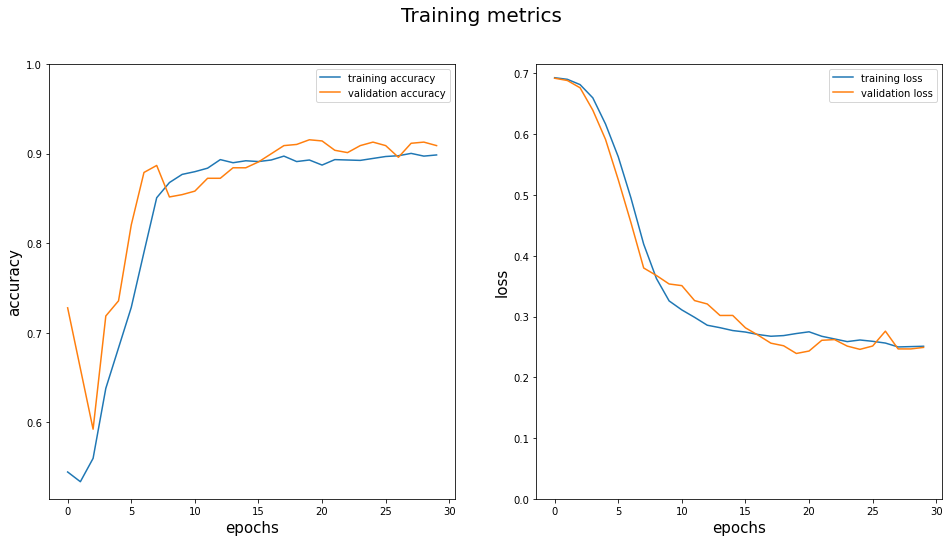

In [6]:
def visualise_results(history):
    def plot_graph(history, metric, label):
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric], '')
        plt.xlabel("epochs", fontsize=15)
        plt.ylabel(label, fontsize=15)
        plt.legend([f'training {label}', f'validation {label}'])

    fig = plt.figure(figsize=(16,8))
    fig.suptitle("Training metrics", fontsize=20)
    plt.subplot(1,2,1)
    plot_graph(history, 'acc', 'accuracy')
    plt.ylim(None,1)
    plt.subplot(1,2,2)
    plot_graph(history, 'loss', 'loss')
    plt.ylim(0,None)

visualise_results(history)

## Evaluating the model

In [23]:
X = np.zeros((ds.test_size * batch_size, 200, 200, 3))
y_true = np.zeros((ds.test_size * batch_size, 1))
i = 0
for x, y in ds.actual_test_ds.unbatch().as_numpy_iterator():
    X[i] = x
    y_true[i] = y
    i += 1

In [24]:
metrics = model.evaluate(X, y_true, verbose=1, batch_size=batch_size, steps=ds.test_size)
print(f'Test loss: {metrics[0]:.4f}')
print(f'Test accuracy: {metrics[1]:.2f}%')

12/12 [==============================] - 0s 14ms/step - loss: 0.2611 - acc: 0.9076
Test loss: 0.2611
Test accuracy: 0.91%


In [25]:
y_pred = model.predict(X, verbose=1, batch_size=batch_size, steps=ds.test_size)
y_pred = y_pred > 0.5

12/12 [==============================] - 0s 13ms/step


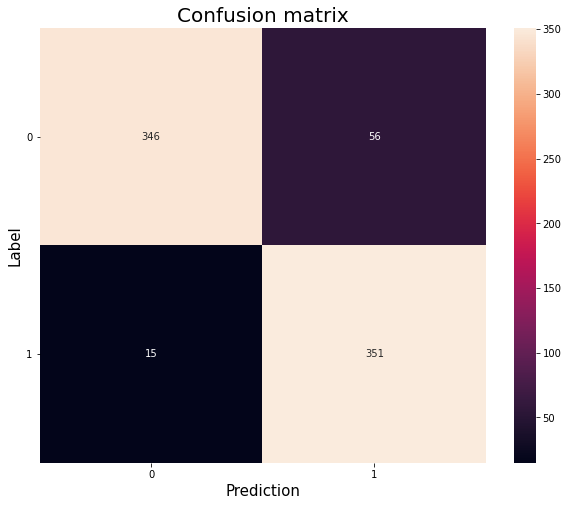

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,  annot=True, fmt='g')
plt.title("Confusion matrix", fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Label', fontsize=15)
plt.yticks(rotation=0)
plt.show()

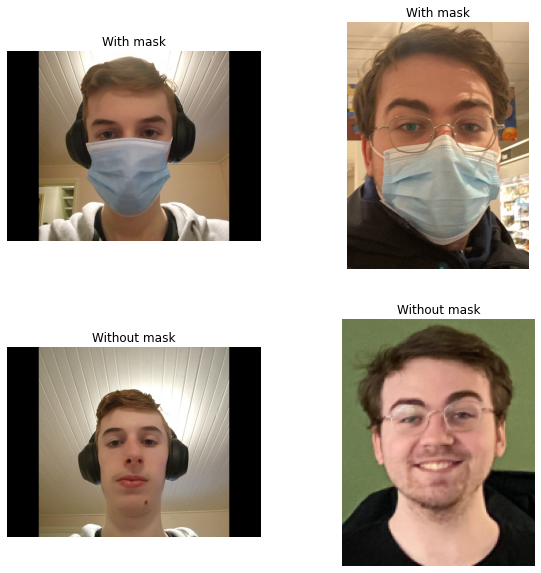

In [29]:
import PIL
path = pathlib.Path(root_path + '/data/self_images')
array = [{ "image_path": "/data/self_images/flyn_with_mask.jpg", "Mask": True, "Rotate": True},
        { "image_path": "/data/self_images/mario_with_mask.jpg", "Mask": True, "Rotate": False},
        { "image_path": "/data/self_images/flyn_without_mask.jpg", "Mask": False, "Rotate": True},
        { "image_path": "/data/self_images/mario_without_mask.jpg", "Mask": False, "Rotate": False}]

plt.figure(figsize=(10, 10))
i = 0
img_list = list()
for image_dict in array:
    image = PIL.Image.open(root_path + image_dict['image_path'])
    image = image.convert('RGB')
    if image_dict['Rotate']:
         image = image.rotate(90)
    img_list.append(image)
    masked = "Without mask"
    if image_dict['Mask']:
        masked = "With mask"
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(masked)
    plt.axis("off")
    i+=1

prediction: True
prediction: True
prediction: False
prediction: False


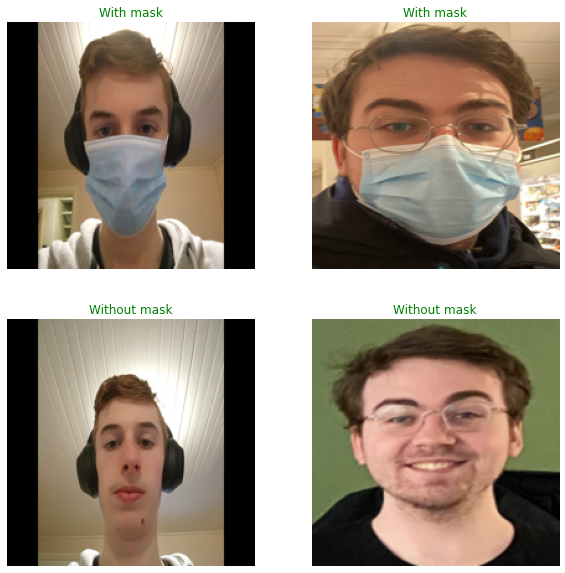

In [30]:
inputs = np.zeros((4, 200, 200, 3))

for i in range(len(img_list)):
    img = img_list[i]
    img = img.resize((200,200))
    img = np.asarray(img)
    inputs[i] = img
    
predictions = model.predict(inputs)
y_true = [True, True, False, False]

plt.figure(figsize=(10, 10))
i = 0
for x, y_pred, y in zip(img_list, predictions, y_true):
    color = 'r'
    masked = "Without mask"
    if (y_pred[0] > 0.5) == y:
        color = 'g'
    print('prediction:', y_pred[0]>0.5)
    if y:
        masked = "With mask"
    fontdict = { 'color': color }
    ax = plt.subplot(2, 2, i + 1)
    x = x.resize((200,200))
    plt.imshow(x)    
    plt.axis("off")
    plt.title(masked, fontdict = fontdict)
    i+=1